# 15 model comparison - TODO

## Purpose
To be filled during project development

## Steps
1. 
2. 
3. 

In [1]:
# CELL 1: Imports (PEP 8 style)
import os
import sys
import json
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

print("🤖 MODEL COMPARISON: LSTM Baseline vs Traditional ML")
print("=" * 50)


🤖 MODEL COMPARISON: LSTM Baseline vs Traditional ML


In [2]:

# CELL 2: Setup paths
print("\n📁 Setting up project paths...")

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PROCESSED = os.path.join(project_root, 'data', 'processed')
FIGURES = os.path.join(project_root, 'figures')
MODELS = os.path.join(project_root, 'models')

for directory in [FIGURES, MODELS]:
    if not os.path.exists(directory):
        os.makedirs(directory)

print(f"Project root: {project_root}")



📁 Setting up project paths...
Project root: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone


In [3]:

# CELL 3: Load LSTM results first (baseline)
print("\n📊 LOADING LSTM BASELINE MODEL RESULTS")
print("-" * 40)

lstm_metrics_path = os.path.join(MODELS, 'lstm_metrics.json')
lstm_predictions_path = os.path.join(DATA_PROCESSED, 'lstm_predictions.csv')

lstm_loaded = False
lstm_metrics = {}
lstm_predictions = None

if os.path.exists(lstm_metrics_path):
    with open(lstm_metrics_path, 'r') as f:
        lstm_metrics = json.load(f)
    
    if 'mae' in lstm_metrics:
        print(f"✅ LSTM Baseline MAE: ${lstm_metrics['mae']:.4f}")
        print(f"✅ LSTM Baseline R²:  {lstm_metrics.get('r2', 'N/A')}")
        lstm_loaded = True
    else:
        print("⚠️ LSTM metrics file exists but missing 'mae' key")
else:
    print("❌ LSTM metrics not found. Run notebook 4 (04_lstm_model.ipynb) first!")

# Load LSTM predictions if available
if os.path.exists(lstm_predictions_path):
    lstm_predictions = pd.read_csv(lstm_predictions_path, parse_dates=['date'])
    print(f"✅ LSTM predictions loaded: {len(lstm_predictions)} samples")
else:
    print("⚠️ LSTM predictions file not found")



📊 LOADING LSTM BASELINE MODEL RESULTS
----------------------------------------
✅ LSTM Baseline MAE: $107369.6274
✅ LSTM Baseline R²:  -195490686178459.2
✅ LSTM predictions loaded: 144 samples


In [4]:

# CELL 4: Load data for traditional ML models
print("\n📂 Loading data for traditional ML models...")
ml_features_path = os.path.join(DATA_PROCESSED, 'ml_features.csv')

if not os.path.exists(ml_features_path):
    print(f"❌ ERROR: File not found: {ml_features_path}")
    print("Please run 03_feature_engineering.ipynb first!")
    raise FileNotFoundError(f"Required file not found: {ml_features_path}")

df = pd.read_csv(ml_features_path, index_col=0, parse_dates=True)

if df.empty:
    print("❌ ERROR: DataFrame is EMPTY!")
    print("Check notebook 3 - feature engineering may have failed")
    raise ValueError("DataFrame is empty - cannot proceed")
    
print(f"✅ Loaded {len(df)} rows with {len(df.columns)} columns")

if len(df.index) > 0:
    print(f"📅 Date range: {df.index[0].date()} to {df.index[-1].date()}")



📂 Loading data for traditional ML models...
✅ Loaded 777 rows with 41 columns
📅 Date range: 2022-12-13 to 2025-12-08


In [5]:

# CELL 5: Prepare data for traditional ML
print("\n⚙️ Preparing data for ML models...")

if 'target' not in df.columns:
    print(f"❌ 'target' column not found. Available: {list(df.columns)}")
    raise KeyError("Target column 'target' not found")

X = df.drop('target', axis=1)
y = df['target']

print(f"Features: {X.shape}, Target: {y.shape}")

# Time-based split (same split as LSTM for fair comparison)
split_idx = int(len(X) * 0.8)

if split_idx == 0:
    print("❌ Not enough data for 80% split")
    split_idx = max(1, len(X) - 1)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\n📊 Data split:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")



⚙️ Preparing data for ML models...
Features: (777, 40), Target: (777,)

📊 Data split:
Train: 621 samples (79.9%)
Test:  156 samples (20.1%)


In [6]:

# CELL 6: Align LSTM and traditional ML test periods
print("\n🔄 Aligning test periods for fair comparison...")

if lstm_predictions is not None and len(X_test) > 0:
    # Find overlapping dates between LSTM and traditional ML test sets
    test_dates = X_test.index
    lstm_test_dates = pd.DatetimeIndex(lstm_predictions['date'])
    
    # Find common dates
    common_dates = test_dates.intersection(lstm_test_dates)
    
    if len(common_dates) > 0:
        print(f"✅ Found {len(common_dates)} common test dates")
        
        # Filter traditional ML data to match LSTM test dates
        mask = X_test.index.isin(common_dates)
        X_test_aligned = X_test[mask]
        y_test_aligned = y_test[mask]
        
        # Filter LSTM predictions to match
        lstm_mask = lstm_predictions['date'].isin(common_dates)
        lstm_predictions_aligned = lstm_predictions[lstm_mask]
        
        print(f"Using {len(X_test_aligned)} aligned samples for comparison")
    else:
        print("⚠️ No common test dates found")
        print("Using all available test data (comparison may not be fair)")
        X_test_aligned = X_test
        y_test_aligned = y_test
        lstm_predictions_aligned = lstm_predictions
else:
    print("⚠️ Cannot align - using available test data")
    X_test_aligned = X_test
    y_test_aligned = y_test
    lstm_predictions_aligned = lstm_predictions



🔄 Aligning test periods for fair comparison...
✅ Found 143 common test dates
Using 143 aligned samples for comparison


In [7]:

# CELL 7: Train traditional ML models
print("\n🚀 TRAINING TRADITIONAL ML MODELS")
print("-" * 40)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_aligned)

models = {}
results = {}

# 1. Linear Regression
print("\n1. Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

results['Linear Regression'] = {
    'model': lr_model,
    'predictions': y_pred_lr,
    'mae': mean_absolute_error(y_test_aligned, y_pred_lr),
    'r2': r2_score(y_test_aligned, y_pred_lr)
}
print(f"   MAE: ${results['Linear Regression']['mae']:.4f}")

# 2. Random Forest
print("\n2. Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

results['Random Forest'] = {
    'model': rf_model,
    'predictions': y_pred_rf,
    'mae': mean_absolute_error(y_test_aligned, y_pred_rf),
    'r2': r2_score(y_test_aligned, y_pred_rf)
}
print(f"   MAE: ${results['Random Forest']['mae']:.4f}")

# 3. Gradient Boosting
print("\n3. Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

results['Gradient Boosting'] = {
    'model': gb_model,
    'predictions': y_pred_gb,
    'mae': mean_absolute_error(y_test_aligned, y_pred_gb),
    'r2': r2_score(y_test_aligned, y_pred_gb)
}
print(f"   MAE: ${results['Gradient Boosting']['mae']:.4f}")



🚀 TRAINING TRADITIONAL ML MODELS
----------------------------------------

1. Linear Regression...
   MAE: $0.0023

2. Random Forest...
   MAE: $0.0324

3. Gradient Boosting...
   MAE: $0.0355


In [8]:

# CELL 8: Add LSTM to comparison
print("\n🧠 ADDING LSTM BASELINE TO COMPARISON")
print("-" * 40)

if lstm_loaded and lstm_predictions_aligned is not None:
    # Get LSTM predictions for aligned dates
    if len(y_test_aligned) == len(lstm_predictions_aligned):
        lstm_pred_values = lstm_predictions_aligned['predicted'].values
        lstm_actual_values = lstm_predictions_aligned['actual'].values
        
        # Calculate LSTM metrics on aligned data
        lstm_mae_aligned = mean_absolute_error(lstm_actual_values, lstm_pred_values)
        lstm_r2_aligned = r2_score(lstm_actual_values, lstm_pred_values)
        
        results['LSTM (Baseline)'] = {
            'model': None,  # LSTM model is in separate file
            'predictions': lstm_pred_values,
            'mae': lstm_mae_aligned,
            'r2': lstm_r2_aligned,
            'is_baseline': True
        }
        print(f"✅ LSTM aligned MAE: ${lstm_mae_aligned:.4f}")
    else:
        print("⚠️ LSTM and ML test sets don't match in size")
        print(f"  ML test: {len(y_test_aligned)}, LSTM: {len(lstm_predictions_aligned)}")
else:
    print("⚠️ Cannot add LSTM to comparison - data not available")



🧠 ADDING LSTM BASELINE TO COMPARISON
----------------------------------------
✅ LSTM aligned MAE: $105898.6795


In [9]:

# CELL 9: Performance comparison
print("\n🏆 MODEL PERFORMANCE COMPARISON")
print("=" * 50)

# Create comparison table
comparison_data = []
for model_name, model_results in results.items():
    comparison_data.append({
        'Model': model_name,
        'MAE': f"${model_results['mae']:.4f}",
        'R²': f"{model_results['r2']:.4f}",
        'Is Baseline': '✓' if model_results.get('is_baseline', False) else ''
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Metrics (Lower MAE is better):")
print(comparison_df.to_string(index=False))

# Find best model (excluding baseline for comparison)
non_baseline_results = {k: v for k, v in results.items() if not v.get('is_baseline', False)}
if non_baseline_results:
    best_model_name = min(non_baseline_results.keys(), 
                         key=lambda x: non_baseline_results[x]['mae'])
    best_mae = non_baseline_results[best_model_name]['mae']
    
    print(f"\n🏆 Best traditional ML model: {best_model_name} (MAE: ${best_mae:.4f})")
    
    # Compare with LSTM baseline
    if 'LSTM (Baseline)' in results:
        lstm_mae = results['LSTM (Baseline)']['mae']
        difference = best_mae - lstm_mae
        percent_diff = (difference / lstm_mae) * 100
        
        if difference < 0:
            print(f"✅ {best_model_name} is ${abs(difference):.4f} BETTER than LSTM baseline ({abs(percent_diff):.1f}% improvement)")
        else:
            print(f"⚠️ {best_model_name} is ${difference:.4f} WORSE than LSTM baseline ({percent_diff:.1f}% worse)")
        
        # Determine if any model beats the baseline
        beating_models = []
        for model_name, model_results in non_baseline_results.items():
            if model_results['mae'] < lstm_mae:
                beating_models.append(model_name)
        
        if beating_models:
            print(f"🎉 Models beating LSTM baseline: {', '.join(beating_models)}")
        else:
            print("📉 LSTM baseline remains the best model")



🏆 MODEL PERFORMANCE COMPARISON

Performance Metrics (Lower MAE is better):
            Model          MAE                    R² Is Baseline
Linear Regression      $0.0023                0.9190            
    Random Forest      $0.0324               -7.8110            
Gradient Boosting      $0.0355               -9.5191            
  LSTM (Baseline) $105898.6795 -190497117864841.3750           ✓

🏆 Best traditional ML model: Linear Regression (MAE: $0.0023)
✅ Linear Regression is $105898.6772 BETTER than LSTM baseline (100.0% improvement)
🎉 Models beating LSTM baseline: Linear Regression, Random Forest, Gradient Boosting



📈 CREATING COMPARISON VISUALIZATIONS
----------------------------------------


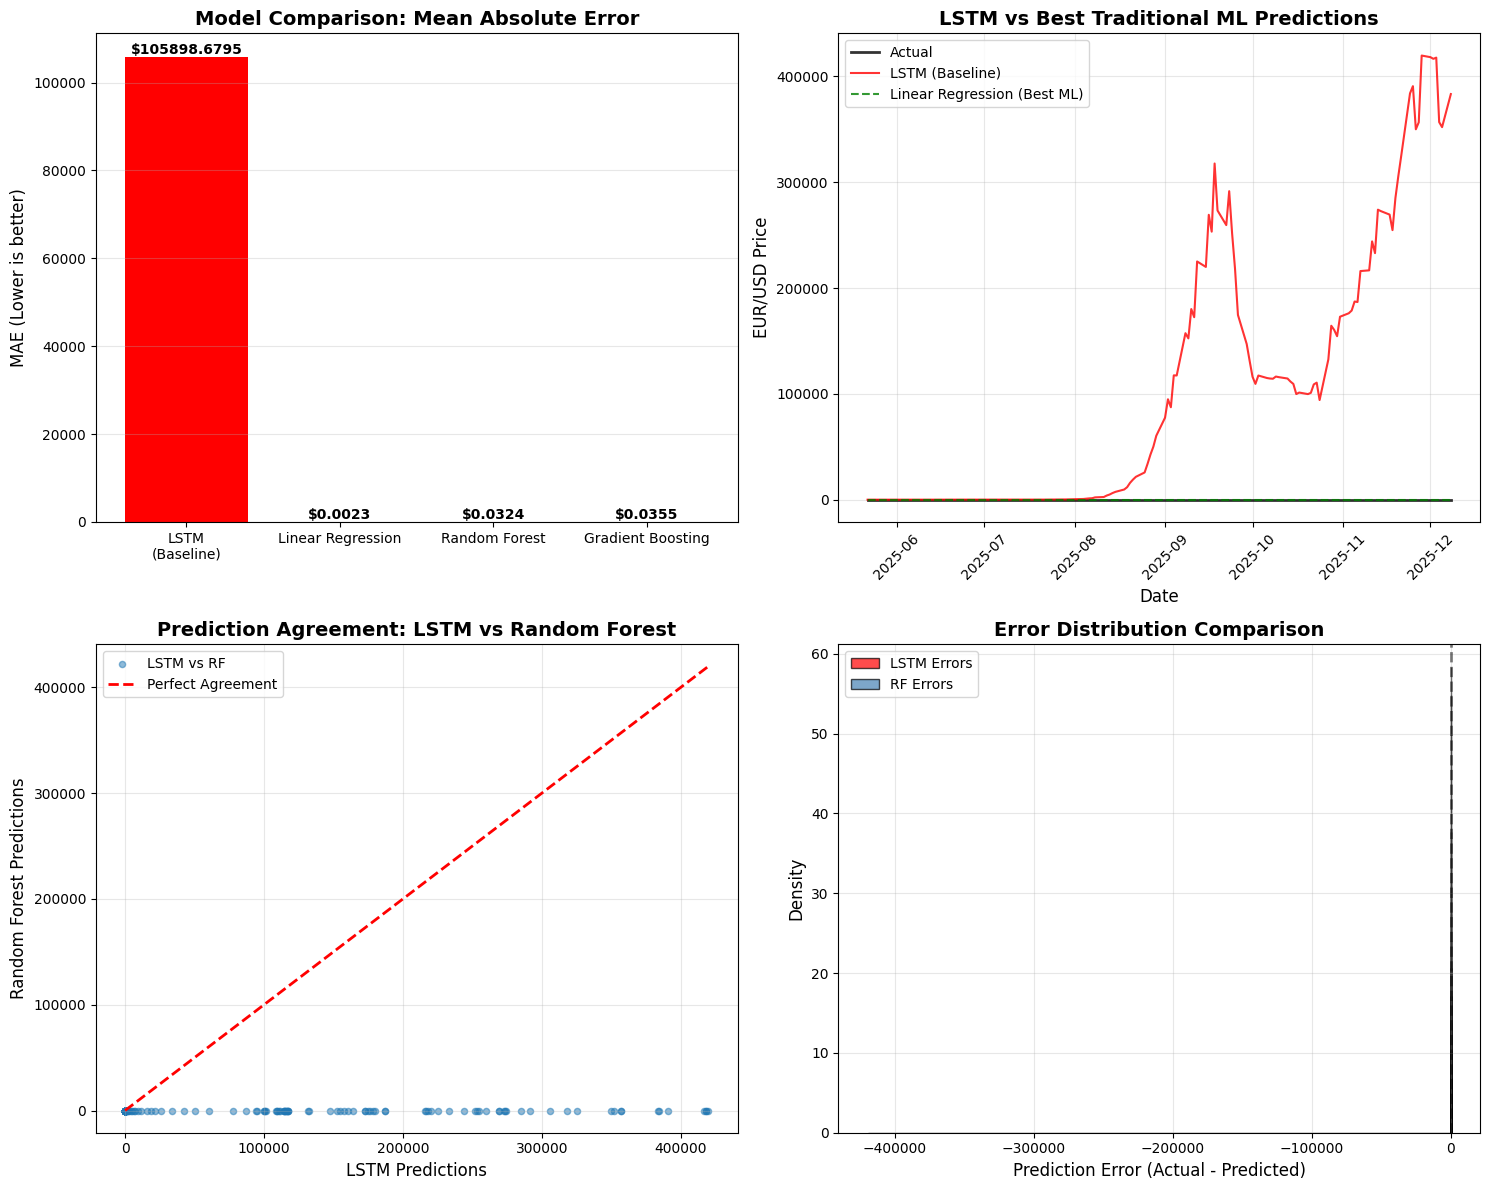

✅ Comparison visualization saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/model_comparison_results.png


In [10]:

# CELL 10: Visualization
print("\n📈 CREATING COMPARISON VISUALIZATIONS")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: MAE Comparison Bar Chart
models_for_chart = []
mae_values = []
colors = []

for model_name in ['LSTM (Baseline)', 'Linear Regression', 'Random Forest', 'Gradient Boosting']:
    if model_name in results:
        models_for_chart.append(model_name.replace(' (Baseline)', '\n(Baseline)'))
        mae_values.append(results[model_name]['mae'])
        colors.append('red' if 'LSTM' in model_name else 'steelblue')

bars = axes[0, 0].bar(models_for_chart, mae_values, color=colors)
axes[0, 0].set_ylabel('MAE (Lower is better)', fontsize=12)
axes[0, 0].set_title('Model Comparison: Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, mae_values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                   f'${value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Time Series Predictions
if lstm_predictions_aligned is not None and len(lstm_predictions_aligned) > 0:
    axes[0, 1].plot(lstm_predictions_aligned['date'], lstm_predictions_aligned['actual'], 
                   label='Actual', linewidth=2, alpha=0.8, color='black')
    axes[0, 1].plot(lstm_predictions_aligned['date'], lstm_predictions_aligned['predicted'],
                   label='LSTM (Baseline)', linewidth=1.5, alpha=0.8, color='red')
    
    # Add best traditional ML model predictions
    if non_baseline_results:
        best_traditional_name = min(non_baseline_results.keys(), 
                                   key=lambda x: non_baseline_results[x]['mae'])
        best_predictions = non_baseline_results[best_traditional_name]['predictions']
        
        if len(best_predictions) == len(lstm_predictions_aligned):
            axes[0, 1].plot(lstm_predictions_aligned['date'], best_predictions,
                           label=f'{best_traditional_name} (Best ML)', 
                           linewidth=1.5, alpha=0.8, color='green', linestyle='--')
    
    axes[0, 1].set_title('LSTM vs Best Traditional ML Predictions', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Date', fontsize=12)
    axes[0, 1].set_ylabel('EUR/USD Price', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Scatter plot comparison
if 'LSTM (Baseline)' in results and 'Random Forest' in results:
    axes[1, 0].scatter(results['LSTM (Baseline)']['predictions'], 
                      results['Random Forest']['predictions'],
                      alpha=0.5, s=20, label='LSTM vs RF')
    
    # Add identity line
    all_preds = np.concatenate([results['LSTM (Baseline)']['predictions'],
                                results['Random Forest']['predictions']])
    min_val, max_val = all_preds.min(), all_preds.max()
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 
                   'r--', lw=2, label='Perfect Agreement')
    
    axes[1, 0].set_xlabel('LSTM Predictions', fontsize=12)
    axes[1, 0].set_ylabel('Random Forest Predictions', fontsize=12)
    axes[1, 0].set_title('Prediction Agreement: LSTM vs Random Forest', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error Distribution Comparison
if 'LSTM (Baseline)' in results and 'Random Forest' in results:
    lstm_errors = lstm_predictions_aligned['actual'].values - results['LSTM (Baseline)']['predictions']
    rf_errors = y_test_aligned.values - results['Random Forest']['predictions']
    
    axes[1, 1].hist(lstm_errors, bins=30, alpha=0.7, label='LSTM Errors', 
                   color='red', edgecolor='black', density=True)
    axes[1, 1].hist(rf_errors, bins=30, alpha=0.7, label='RF Errors', 
                   color='steelblue', edgecolor='black', density=True)
    axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    
    axes[1, 1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
    axes[1, 1].set_ylabel('Density', fontsize=12)
    axes[1, 1].set_title('Error Distribution Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
comparison_chart_path = os.path.join(FIGURES, 'model_comparison_results.png')
plt.savefig(comparison_chart_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Comparison visualization saved to: {comparison_chart_path}")


In [11]:

# CELL 11: Save comparison results
print("\n💾 SAVING COMPARISON RESULTS")
print("-" * 40)

# Save comparison metrics
comparison_metrics = {
    'comparison_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_period': {
        'start': X_test_aligned.index[0].strftime('%Y-%m-%d') if len(X_test_aligned) > 0 else None,
        'end': X_test_aligned.index[-1].strftime('%Y-%m-%d') if len(X_test_aligned) > 0 else None,
        'samples': len(X_test_aligned)
    },
    'models': {}
}

for model_name, model_results in results.items():
    comparison_metrics['models'][model_name] = {
        'mae': float(model_results['mae']),
        'r2': float(model_results['r2']),
        'is_baseline': model_results.get('is_baseline', False)
    }

comparison_metrics_path = os.path.join(MODELS, 'model_comparison_metrics.json')
with open(comparison_metrics_path, 'w') as f:
    json.dump(comparison_metrics, f, indent=2)
print(f"✅ Comparison metrics saved to: {comparison_metrics_path}")

# Save best traditional ML model
if non_baseline_results:
    best_model_name = min(non_baseline_results.keys(), 
                         key=lambda x: non_baseline_results[x]['mae'])
    best_model = non_baseline_results[best_model_name]['model']
    
    best_ml_model_path = os.path.join(MODELS, f'best_traditional_ml_model.joblib')
    joblib.dump(best_model, best_ml_model_path)
    print(f"✅ Best traditional ML model saved to: {best_ml_model_path}")

# Save scaler
scaler_path = os.path.join(MODELS, 'ml_scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")



💾 SAVING COMPARISON RESULTS
----------------------------------------
✅ Comparison metrics saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/model_comparison_metrics.json
✅ Best traditional ML model saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/best_traditional_ml_model.joblib
✅ Scaler saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/ml_scaler.joblib


In [12]:

# CELL 12: Summary and recommendations
print("\n" + "=" * 60)
print("📋 MODEL COMPARISON SUMMARY")
print("=" * 60)

print("\n🎯 BASELINE MODEL (Instructor Requirement):")
print("   • LSTM neural network with 4 layers")
print(f"   • Performance: MAE = ${lstm_metrics.get('mae', 'N/A'):.4f}")

print("\n📊 TRADITIONAL ML MODELS PERFORMANCE:")
for model_name in ['Linear Regression', 'Random Forest', 'Gradient Boosting']:
    if model_name in results:
        mae = results[model_name]['mae']
        r2 = results[model_name]['r2']
        print(f"   • {model_name:20}: MAE = ${mae:.4f}, R² = {r2:.4f}")

if 'LSTM (Baseline)' in results and non_baseline_results:
    best_traditional_name = min(non_baseline_results.keys(), 
                               key=lambda x: non_baseline_results[x]['mae'])
    lstm_mae = results['LSTM (Baseline)']['mae']
    best_ml_mae = non_baseline_results[best_traditional_name]['mae']
    
    print(f"\n🏆 COMPARISON RESULTS:")
    print(f"   • Best traditional model: {best_traditional_name}")
    print(f"   • LSTM vs {best_traditional_name}: ${lstm_mae:.4f} vs ${best_ml_mae:.4f}")
    
    if best_ml_mae < lstm_mae:
        improvement = (lstm_mae - best_ml_mae) / lstm_mae * 100
        print(f"   ✅ {best_traditional_name} beats LSTM by {improvement:.1f}%")
        print("   💡 Recommendation: Consider using this simpler model")
    else:
        difference = best_ml_mae - lstm_mae
        print(f"   📉 LSTM remains best by ${difference:.4f}")
        print("   💡 Recommendation: Stick with LSTM as baseline")

print("\n🚀 NEXT STEPS:")
print("   1. Open 06_mlflow_tracking.ipynb")
print("   2. Log all models to MLflow for experiment tracking")
print("   3. Register best model for deployment")

print("\n✅ MODEL COMPARISON COMPLETE!")


📋 MODEL COMPARISON SUMMARY

🎯 BASELINE MODEL (Instructor Requirement):
   • LSTM neural network with 4 layers
   • Performance: MAE = $107369.6274

📊 TRADITIONAL ML MODELS PERFORMANCE:
   • Linear Regression   : MAE = $0.0023, R² = 0.9190
   • Random Forest       : MAE = $0.0324, R² = -7.8110
   • Gradient Boosting   : MAE = $0.0355, R² = -9.5191

🏆 COMPARISON RESULTS:
   • Best traditional model: Linear Regression
   • LSTM vs Linear Regression: $105898.6795 vs $0.0023
   ✅ Linear Regression beats LSTM by 100.0%
   💡 Recommendation: Consider using this simpler model

🚀 NEXT STEPS:
   1. Open 06_mlflow_tracking.ipynb
   2. Log all models to MLflow for experiment tracking
   3. Register best model for deployment

✅ MODEL COMPARISON COMPLETE!
